# Multiple Linear Regression

a.k.a. Polynomial Regression ?

In [16]:
# import the necessary libraries we need for the analysis
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

RSEED =  42

In [17]:
import sys;
sys.path.insert(0,'..')
import project_fun as prj

In [18]:
df = pd.read_csv('../data/Train_cleaned.csv', sep=";")
df

,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,AC,target,hour_STA,hour_STD,...,season_num,outcome,country_arr,elevation_arr,lat_arr,lon_arr,country_dep,elevation_dep,lat_dep,lon_dep
0,2016-01-03 00:00:00,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12:55:00,TU 32AIMN,260.0,12,10,...,3,1,TN,22,36.851002,10.22720,MA,656,33.367500,-7.58997
1,2016-01-13 00:00:00,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16:55:00,TU 31BIMO,20.0,16,15,...,3,1,TN,22,36.851002,10.22720,IT,768,45.630600,8.72811
2,2016-01-16 00:00:00,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06:45:00,TU 32AIMN,0.0,6,4,...,3,0,TR,325,41.275333,28.75200,TN,22,36.851002,10.22720
3,2016-01-17 00:00:00,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17:00:00,TU 736IOK,0.0,17,14,...,3,0,FR,90,47.153198,-1.61073,TN,19,33.875000,10.77550
4,2016-01-17 00:00:00,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15:50:00,TU 320IMU,22.0,15,14,...,3,1,DZ,82,36.691002,3.21541,TN,22,36.851002,10.22720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107167,2018-07-05 00:00:00,WKL 0000,TUN,TUN,2018-07-05 23:00:00,2018-07-06 02:00:00,TU 32AIML,0.0,2,23,...,1,0,TN,22,36.851002,10.22720,TN,22,36.851002,10.22720
107168,2018-01-13 00:00:00,UG 0003,DJE,TUN,2018-01-13 08:00:00,2018-01-13 09:00:00,UG AT7AT7,0.0,9,8,...,3,0,TN,22,36.851002,10.22720,TN,19,33.875000,10.77550
107169,2018-11-07 00:00:00,SGT 0000,TUN,TUN,2018-11-07 05:00:00,2018-11-07 12:50:00,TU 736IOK,0.0,12,5,...,2,0,TN,22,36.851002,10.22720,TN,22,36.851002,10.22720
107170,2018-01-23 00:00:00,UG 0010,TUN,DJE,2018-01-23 18:00:00,2018-01-23 18:45:00,TU CR9ISA,0.0,18,18,...,3,0,TN,19,33.875000,10.77550,TN,22,36.851002,10.22720


## Setup data

#### Feature Encoding

To use the countries as input features, we need to convert their abbreviations to numbers, i.e. performing label encoding.

In [19]:
# 1) encode departure countries
le1 = LabelEncoder()
le1.fit(df['country_dep'])
df['country_dep'] = le1.transform(df['country_dep'])

# 2) encode arrival countries
le2 = LabelEncoder()
le2.fit(df['country_arr'])
df['country_arr'] = le2.transform(df['country_arr'])

# 2) encode flight id
le3 = LabelEncoder()
le3.fit(df['FLTID'])
df['FLTID'] = le3.transform(df['FLTID'])

#### Spliting data

In [20]:
# Define features and target
y = df['target']
X = df[['FLTID','hour_STA','hour_STD','country_dep','season_num','elevation_dep','day_of_week']]

# Split the features and target data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RSEED, train_size = .8)

#### Feature Scaling

Before we will apply this model, we will scale our features.

In [21]:
# We have to define which columns we want to scale.
col_scale = ['FLTID','hour_STA','hour_STD','country_dep','season_num','elevation_dep','day_of_week']

In [22]:
# Scaling with standard scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[col_scale])
X_test_scaled = scaler.transform(X_test[col_scale])

## Trainining the model

In [23]:
# What parameters does Linear Regressor have?
LinearRegression().get_params().keys()

dict_keys(['copy_X', 'fit_intercept', 'n_jobs', 'normalize', 'positive'])

### Polynomial Degrees

Here, we want to apply higher order regression by exploring and comparing the results for non-linear degrees.

#### Degree 2

In [24]:
# set the second degree polynomial features
polynomial_features = PolynomialFeatures(degree=2, include_bias=False)
x_poly_train = polynomial_features.fit_transform(X_train)
x_poly_test = polynomial_features.transform(X_test)

In [25]:
# Initializing regressor
model_2_poly = LinearRegression()

In [26]:
# fit the regressor with X_train and y_train data
model_2_poly.fit(x_poly_train, y_train)

LinearRegression()

In [27]:
# Make prediction
y_pred_test = model_2_poly.predict(x_poly_test)
y_pred_train = model_2_poly.predict(x_poly_train)

In [28]:
# Calculate r-squared and RMSE
print("Polynomial Regression Model (degree 2):")
print("---"*10)
prj.calculate_metrics(y_train,y_pred_train, y_test, y_pred_test)

Polynomial Regression Model (degree 2):
------------------------------
Metrics on training data
RMSE: 114.753
R2: 0.043
------------------------------
Metrics on test data
RMSE: 111.311
R2: 0.041
------------------------------


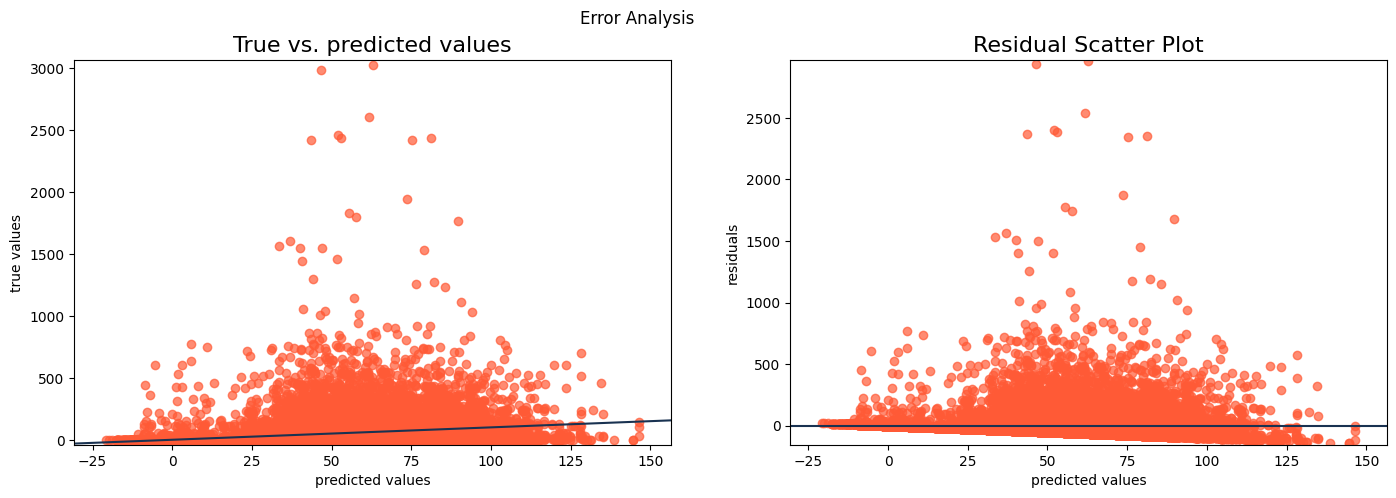

In [29]:
prj.error_analysis(y_test, y_pred_test)

#### Degrees 3 to 5

Polynomial Regression Model (degree 3):
------------------------------
Metrics on training data
RMSE: 114.753
R2: 0.043
------------------------------
Metrics on test data
RMSE: 111.311
R2: 0.041
------------------------------
Polynomial Regression Model (degree 4):
------------------------------
Metrics on training data
RMSE: 114.753
R2: 0.043
------------------------------
Metrics on test data
RMSE: 111.311
R2: 0.041
------------------------------
Polynomial Regression Model (degree 5):
------------------------------
Metrics on training data
RMSE: 114.753
R2: 0.043
------------------------------
Metrics on test data
RMSE: 111.311
R2: 0.041
------------------------------


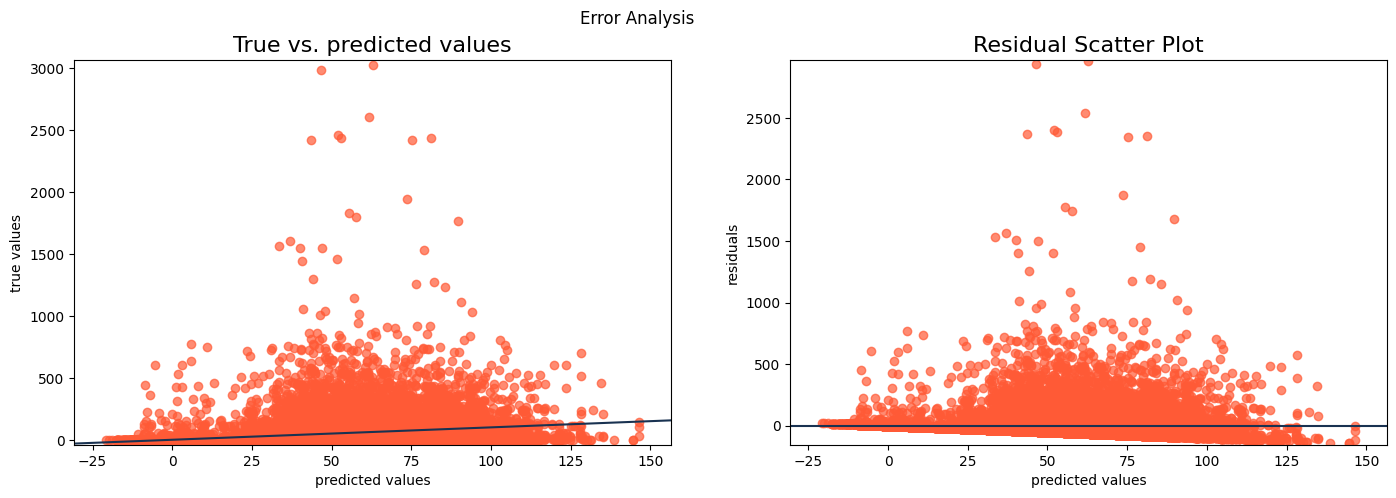

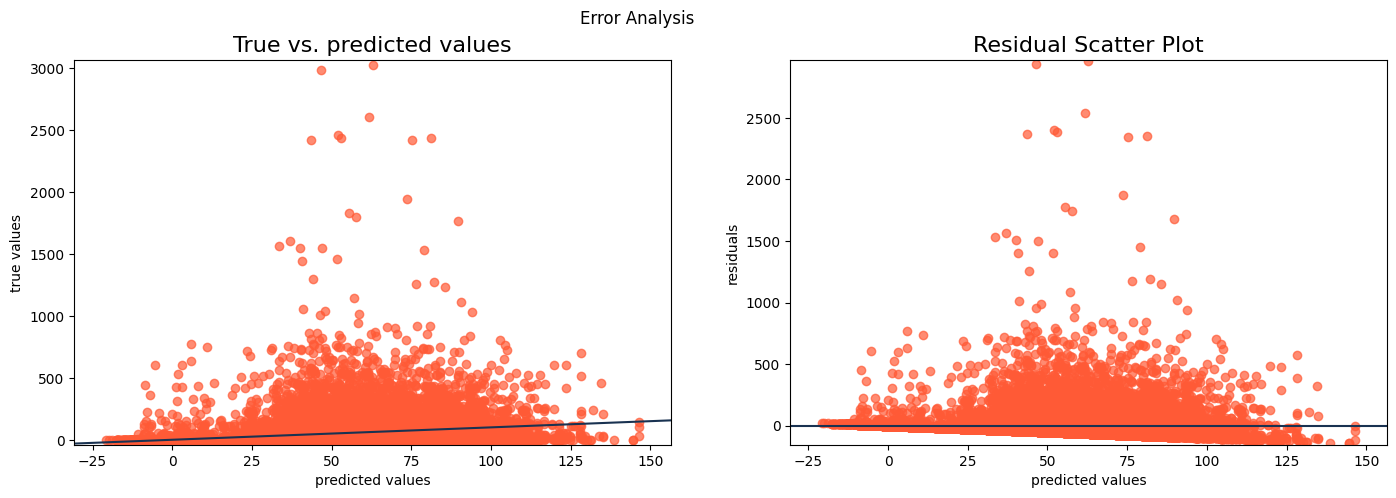

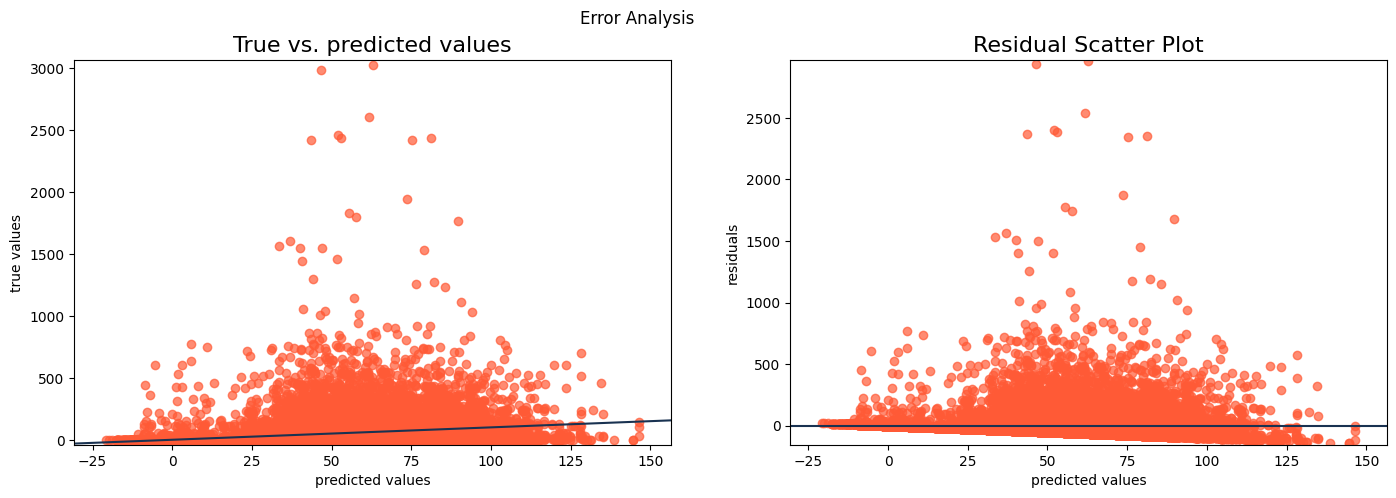

In [30]:
for i in range(3,6):

    # set the second degree polynomial features
    polynomial_features = PolynomialFeatures(degree=2, include_bias=False)
    x_poly_train = polynomial_features.fit_transform(X_train)
    x_poly_test = polynomial_features.transform(X_test)

    # Initializing regressor
    model_poly = LinearRegression()

    # fit the regressor with X_train and y_train data
    model_poly.fit(x_poly_train, y_train)

    # Make prediction
    y_pred_test = model_poly.predict(x_poly_test)
    y_pred_train = model_poly.predict(x_poly_train)

    # Calculate r-squared and RMSE
    print(f"Polynomial Regression Model (degree {i}):")
    print("---"*10)
    prj.calculate_metrics(y_train,y_pred_train, y_test, y_pred_test)

    # visualize errors
    prj.error_analysis(y_test, y_pred_test)



In [31]:
print('Average predicted delay: ', y_pred_test.mean(), ' min')
print('Standard deviation of predicted delay: ', y_pred_test.std(), ' min')

Average predicted delay:  49.24956261993539  min
Standard deviation of predicted delay:  24.241353784513915  min
